<h2 style="color:#1f77b4;">Live Coding Parte 2</h2>

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h5 style="color:#1f77b4;">1. Detecta valores perdidos y aplica técnicas de imputación adecuadas según el tipo de variable.</h5>

In [2]:
# Diagnóstico rápido de nulos
nulos = df.isnull().sum().sort_values(ascending=False)
porc_nulos = (df.isnull().mean() * 100).sort_values(ascending=False)

resumen_nulos = pd.DataFrame({"nulos": nulos, "%": porc_nulos})
resumen_nulos


,nulos,%
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Name,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000
Sex,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000


Imputación (numéricas + categóricas)<br>
* Numéricas: Age (mediana por grupo), Fare (mediana global)
* Categóricas: Embarked (moda), Cabin (nueva categoría “Unknown”)

In [3]:
df_clean = df.copy()

# --- NUMÉRICAS ---
# Age: mediana por grupo (Sex, Pclass) si existen esas columnas
if set(["Age", "Sex", "Pclass"]).issubset(df_clean.columns):
    df_clean["Age"] = df_clean.groupby(["Sex", "Pclass"])["Age"]\
                              .transform(lambda s: s.fillna(s.median()))
else:
    df_clean["Age"] = df_clean["Age"].fillna(df_clean["Age"].median())

# Fare: mediana global
if "Fare" in df_clean.columns:
    df_clean["Fare"] = df_clean["Fare"].fillna(df_clean["Fare"].median())

# --- CATEGÓRICAS ---
# Embarked: moda
if "Embarked" in df_clean.columns:
    moda_embarked = df_clean["Embarked"].mode(dropna=True)[0]
    df_clean["Embarked"] = df_clean["Embarked"].fillna(moda_embarked)

# Cabin: nueva categoría
if "Cabin" in df_clean.columns:
    df_clean["Cabin"] = df_clean["Cabin"].fillna("Unknown")

print("Nulos después (top 10):")
print(df_clean.isnull().sum().sort_values(ascending=False).head(10))


Nulos después (top 10):
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
dtype: int64


<h5 style="color:#1f77b4;">2. Identificar outliers con al menos dos métodos diferentes (uno estadístico y uno basado en ML).</h5>

2.1 IQR (para Fare)

In [4]:
def outliers_iqr(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    mask = (s < low) | (s > high)
    return mask, low, high

mask_fare_iqr, low_fare, high_fare = outliers_iqr(df_clean["Fare"])
print("Outliers Fare (IQR):", mask_fare_iqr.sum())
print("Límites Fare:", low_fare, high_fare)


Outliers Fare (IQR): 116
Límites Fare: -26.724 65.6344


Isolation Forest (multivariable)

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

cols_ml = [c for c in ["Age", "Fare", "SibSp", "Parch"] if c in df_clean.columns]
X = df_clean[cols_ml].copy()

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_scaled = scaler.fit_transform(imputer.fit_transform(X))

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
pred = iso.fit_predict(X_scaled)
score = iso.decision_function(X_scaled)

df_clean["outlier_if"] = (pred == -1)
df_clean["if_score"] = score

df_clean["outlier_if"].value_counts()


outlier_if
False    846
True      45
Name: count, dtype: int64

<h5 style="color:#1f77b4;">3. Aplica winsorización o transformaciones para reducir el impacto de valores extremos.</h5>

Winsorización en Fare

In [6]:
df_wins = df_clean.copy()
df_wins["Fare_wins"] = df_wins["Fare"].clip(lower=low_fare, upper=high_fare)

df_wins[["Fare", "Fare_wins"]].describe()


,Fare,Fare_wins
count,891.000000,891.000000
mean,32.204208,24.046813
std,49.693429,20.481625
min,0.000000,0.000000
25%,7.910400,7.910400
50%,14.454200,14.454200
75%,31.000000,31.000000
max,512.329200,65.634400


Transformación log

In [7]:
df_log = df_clean.copy()
df_log["Fare_log"] = np.log1p(df_log["Fare"])  # log(1+Fare)
df_log[["Fare", "Fare_log"]].describe()


,Fare,Fare_log
count,891.000000,891.000000
mean,32.204208,2.962246
std,49.693429,0.969048
min,0.000000,0.000000
25%,7.910400,2.187218
50%,14.454200,2.737881
75%,31.000000,3.465736
max,512.329200,6.240917


* Winsor: “No cambio el orden, solo recorto extremos.”
* Log: “Comprime valores grandes y reduce asimetría.”

<h5 style="color:#1f77b4;">4. Documenta el flujo y justifica las decisiones tomadas.</h5>

Decisiones

* Se imputo Age con mediana por (Sex, Pclass) para mantener estructura del dataset.
* Se imputo Fare con mediana global por robustez a outliers.
* Se imputo Embarked con moda y Cabin con categoría Unknown para no inventar valores.
* Se detectó outliers con:
  * IQR en Fare (método estadístico univariado).
  * Isolation Forest en (Age, Fare, SibSp, Parch) (método ML multivariado).
* Se redujo el impacto de extremos en Fare mediante winsorización (cap a límites IQR) o transformación log1p.

Extra: 

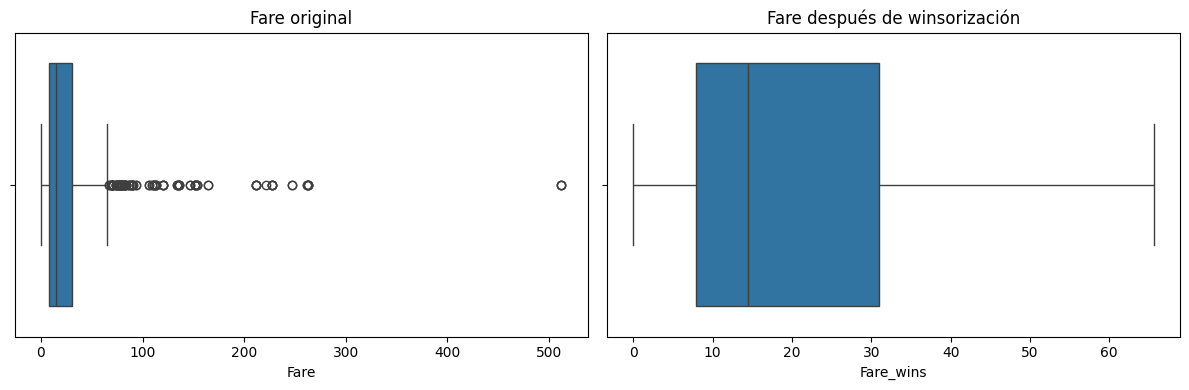

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.boxplot(x=df_clean["Fare"])
plt.title("Fare original")

plt.subplot(1,2,2)
sns.boxplot(x=df_wins["Fare_wins"])
plt.title("Fare después de winsorización")

plt.tight_layout()
plt.show()


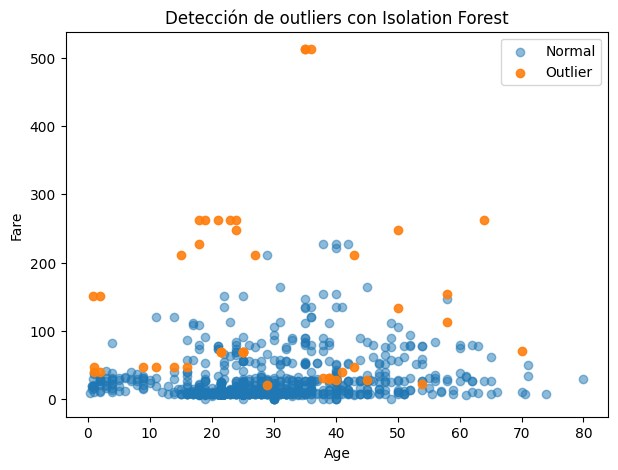

In [9]:
plt.figure(figsize=(7,5))

# Observaciones normales
plt.scatter(
    df_clean.loc[~df_clean["outlier_if"], "Age"],
    df_clean.loc[~df_clean["outlier_if"], "Fare"],
    alpha=0.5,
    label="Normal"
)

# Outliers detectados
plt.scatter(
    df_clean.loc[df_clean["outlier_if"], "Age"],
    df_clean.loc[df_clean["outlier_if"], "Fare"],
    alpha=0.9,
    label="Outlier"
)

plt.xlabel("Age")
plt.ylabel("Fare")
plt.title("Detección de outliers con Isolation Forest")
plt.legend()
plt.show()
